## [ISWD] Project 1: UTA - Agnieszka Klimek (145302), Anna Prałat (145395)

Criteria description:
* **The total financial cost (criterion C1)** = This criterion represents the total of the expenses which are necessary to cover all the technical costs incurred before, during and after dumping of the radioactive wastes
* **The "polluter-pays principle" (criteria C2 z and C3)**, it corresponds to the electronuclear production generating the wastes to be buried into the repository:
    - **C2** represents the costs incurred by the present consumers;
    - **C3** = costs to be supported by the future consumers (although they did not take advantage of the t = 0 -> 30 year electronuclear production)
* **Financial risk due to overcosts (C4)**: related to a wrong assessment: for example, in the case of the kWh-financing
(F1), the risk is to be short of payments after the thirty year fee raising for the fund

All criteria are cost-type.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import *

### Setup

In [45]:
dataset = pd.read_csv("resources/nuclear-waste.csv", index_col=0)
dataset

,C1,C2,C3,C4
index,,,,
1,0.60,0.93,0.00,0.73
2,0.66,0.55,0.45,0.49
3,1.00,0.45,0.57,0.50
4,0.48,0.87,0.00,0.75
5,0.62,0.40,0.56,0.50
6,0.78,0.27,0.71,0.50
7,0.40,0.90,0.00,0.82
8,0.64,0.44,0.54,0.54
9,0.65,0.30,0.71,0.55


In [46]:
u = pd.DataFrame.from_dict({
    f"C{criterion}": {
        value: LpVariable(
            name=f"{criterion}_{value}", lowBound=0, upBound=1, cat="Continuous"
        )
        for value in range(0, 100 + 1)
    }
    for criterion in range(1, 4 + 1)
})

u

,C1,C2,C3,C4
0,1_0,2_0,3_0,4_0
1,1_1,2_1,3_1,4_1
2,1_2,2_2,3_2,4_2
3,1_3,2_3,3_3,4_3
4,1_4,2_4,3_4,4_4
...,...,...,...,...
96,1_96,2_96,3_96,4_96
97,1_97,2_97,3_97,4_97
98,1_98,2_98,3_98,4_98
99,1_99,2_99,3_99,4_99


In [47]:
min_max = pd.DataFrame.from_dict({
    f"C{criterion}": {
        "best": min(dataset[f"C{criterion}"]),
        "worst": max(dataset[f"C{criterion}"]),
    }
    for criterion in range(1, 5)
})

min_max

,C1,C2,C3,C4
best,0.32,0.03,0.0,0.49
worst,1.00,1.00,1.0,1.00


In [48]:
# constraints for reference pairs
def add_reference_alternatives(model, a: int, b: int, epsilon: None | LpVariable = None) -> None:
    a_variant = (dataset.loc[a] * 100).astype(np.int8)
    b_variant = (dataset.loc[b] * 100).astype(np.int8)

    if epsilon is None:
        model.addConstraint(
            u.C1[a_variant.C1] + u.C2[a_variant.C2] + u.C3[a_variant.C3] + u.C4[a_variant.C4]
            == u.C1[b_variant.C1] + u.C2[b_variant.C2] + u.C3[b_variant.C3] + u.C4[b_variant.C4]
        )
    else:
        model.addConstraint(
            u.C1[a_variant.C1] + u.C2[a_variant.C2] + u.C3[a_variant.C3] + u.C4[a_variant.C4]
            >= u.C1[b_variant.C1] + u.C2[b_variant.C2] + u.C3[b_variant.C3] + u.C4[b_variant.C4] + epsilon
        )

In [71]:
def normalization_condition(model) -> None:
    limits = (min_max * 100).astype(np.uint8)

    model.addConstraint(
        (u.C1[limits.C1.best] + u.C2[limits.C2.best] + u.C3[limits.C3.best] + u.C4[limits.C4.best] == 1),
        "#normalization"
    )

    model.addConstraint(u.C1[limits.C1.worst] == 0, "#criterion 1 worst value")
    model.addConstraint(u.C2[limits.C2.worst] == 0, "#criterion 2 worst value")
    model.addConstraint(u.C3[limits.C3.worst] == 0, "#criterion 3 worst value")
    model.addConstraint(u.C4[limits.C4.worst] == 0, "#criterion 4 worst value")

In [72]:
def monotonicity_and_non_negativity_condition(model) -> None:
    for criterion in dataset.columns:
        values = sorted(set((dataset[criterion] * 100).astype(np.int8)))
        print(values)
        for c_value in values:
            model += u[criterion][c_value] >= 0
        
        for i in range(1, len(values)):
            model += u[criterion][values[i - 1]] >= u[criterion][values[i]]

### UTA Method

In [73]:
def solver_main_function(epsilon) -> LpProblem:
    model = LpProblem(name="nuclear-waste-management", sense=LpMaximize)

    # reference pairs
    references = [
      (5, 8),
      (8, 6),
      (6, 3),
      (3, 15),
      (15, 21),
      (21, 27, True),
      (27, 26, True),
      (26, 1),
      (1, 7),
    ]
    for reference in references:
        if len(reference) == 2:
            add_reference_alternatives(model, *reference, epsilon)
        else:
            add_reference_alternatives(model, *reference[:-1])

    # constraints
    normalization_condition(model)
    monotonicity_and_non_negativity_condition(model)
    
    return model

# solving
epsilon = LpVariable(name="epsilon", lowBound=0, cat="Continuous")
model = solver_main_function(epsilon)
model.setObjective(epsilon)

status = model.solve()

print(f"status: {model.status}, {LpStatus[model.status]}")
print(f"objective: {model.objective.value()}")


[32, 34, 35, 40, 44, 45, 48, 59, 60, 61, 62, 64, 65, 66, 68, 69, 71, 73, 74, 76, 78, 80, 83, 87, 100]
[3, 6, 22, 24, 25, 27, 30, 40, 44, 45, 49, 54, 55, 83, 86, 87, 90, 91, 93, 95, 97, 100]
[0, 38, 45, 54, 56, 65, 70, 71, 80, 81, 88, 100]
[49, 50, 54, 55, 60, 61, 63, 65, 67, 73, 75, 82, 90, 91, 94, 98, 100]
status: 1, Optimal
objective: 0.11111111


In [ ]:
def make_subplot(criterion: str, axs: np.ndarray, i: int, j: int):
    values = sorted(set((dataset[criterion] * 100).astype(np.int8)))

    print(values)

    u_values = [xd for i, xd in enumerate(u[criterion]) if i in values]

    print(u_values)
    print([a.value() for a in u_values])

    axs[i, j].plot(
        [x/100 for x in values],
        [round(a.value(), 10) for a in u_values]
    )
    axs[i, j].set_title(criterion)

[32, 34, 35, 40, 44, 45, 48, 59, 60, 61, 62, 64, 65, 66, 68, 69, 71, 73, 74, 76, 78, 80, 83, 87, 100]
[1_32, 1_34, 1_35, 1_40, 1_44, 1_45, 1_48, 1_59, 1_60, 1_61, 1_62, 1_64, 1_65, 1_66, 1_68, 1_69, 1_71, 1_73, 1_74, 1_76, 1_78, 1_80, 1_83, 1_87, 1_100]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[3, 6, 22, 24, 25, 27, 30, 40, 44, 45, 49, 54, 55, 83, 86, 87, 90, 91, 93, 95, 97, 100]
[2_3, 2_6, 2_22, 2_24, 2_25, 2_27, 2_30, 2_40, 2_44, 2_45, 2_49, 2_54, 2_55, 2_83, 2_86, 2_87, 2_90, 2_91, 2_93, 2_95, 2_97, 2_100]
[0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.22222222, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0, 38, 45, 54, 56, 65, 70, 71, 80, 81, 88, 100]
[3_0, 3_38, 3_45, 3_54, 3_56, 3_65, 3_70, 3_71, 3_80, 3_81, 3_88, 3_100]
[0.22222222, 0.22222222, 0.22222222, 0.22222222, 0.22222222, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[49, 50,

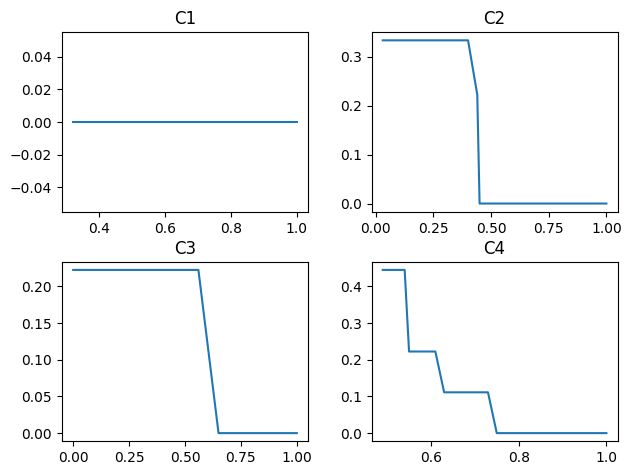

In [70]:
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.5)

make_subplot("C1", axs, 0, 0)
make_subplot("C2", axs, 0, 1)
make_subplot("C3", axs, 1, 0)
make_subplot("C4", axs, 1, 1)

plt.show()

In [ ]:
ranking = pd.DataFrame(dataset.copy())

for criterion in dataset.columns:
    ranking[f"U({criterion})"] = [0 for _ in range(27)]
ranking["U"] = [0 for _ in range(27)]

for criterion in dataset.columns:
    for variant in dataset.index:
        u_arg = (dataset[criterion][variant] * 100).astype(np.int8)
        ranking[f"U({criterion})"][variant] += round(u[criterion][u_arg].value(), 10)

for variant in dataset.index:
    ranking["U"][variant] = np.sum(ranking.loc[variant][5:])


ranking.sort_values('U', ascending=False)

### UTA GMS - Finding Necessary and Possible Relations

In [52]:
# constraints for verifying the truth of the necessary and possible relations
def add_relation_to_model(model, a: int, b: int, epsilon: None | LpVariable = None) -> None:
    a_variant = (dataset.loc[a] * 100).astype(np.int8)
    b_variant = (dataset.loc[b] * 100).astype(np.int8)

    if epsilon is None:
        model.addConstraint(
            u.C1[a_variant.C1] + u.C2[a_variant.C2] + u.C3[a_variant.C3] + u.C4[a_variant.C4]
            >= u.C1[b_variant.C1] + u.C2[b_variant.C2] + u.C3[b_variant.C3] + u.C4[b_variant.C4]
        )
    else:
        model.addConstraint(
            u.C1[a_variant.C1] + u.C2[a_variant.C2] + u.C3[a_variant.C3] + u.C4[a_variant.C4]
            >= u.C1[b_variant.C1] + u.C2[b_variant.C2] + u.C3[b_variant.C3] + u.C4[b_variant.C4] + epsilon
        )

In [53]:
def solver_uta_gms(a: int, b: int, necessary: bool) -> LpProblem:
    epsilon = LpVariable(name="epsilon", lowBound=0, cat="Continuous")
    model = solver_main_function(epsilon)
    model.setObjective(epsilon)

    if necessary:
        add_relation_to_model(model, b, a, epsilon)
    else:
        add_relation_to_model(model, a, b)

    status = model.solve()

    return model.objective.value(), status

relations = []
necessary_relations = np.zeros((27, 27))
for i in range(necessary_relations.shape[0]):
    for j in range(necessary_relations.shape[1]):
        if i == j:
            continue
        result_necessary, status_necessary = solver_uta_gms(i + 1, j + 1, necessary=True)
        if result_necessary <= 0 or status_necessary == -1:
            print(f'necessary = ({i + 1}, {j + 1})')
            relations.append([i + 1, j + 1])
            necessary_relations[i, j] = 1
        
        result_possible, status_possible = solver_uta_gms(i + 1, j + 1, necessary=False)
        if result_possible >= 0 and status_possible == 1:
            print(f'possible = ({i + 1}, {j + 1})')

possible = (1, 2)
possible = (1, 3)
possible = (1, 4)
possible = (1, 5)
possible = (1, 6)
necessary = (1, 7)
possible = (1, 7)
possible = (1, 8)
possible = (1, 9)
possible = (1, 10)
possible = (1, 11)
possible = (1, 12)
necessary = (1, 13)
possible = (1, 13)
possible = (1, 14)
possible = (1, 15)
necessary = (1, 16)
possible = (1, 16)
possible = (1, 17)
possible = (1, 18)
possible = (1, 19)
possible = (1, 20)
possible = (1, 21)
possible = (1, 22)
possible = (1, 23)
possible = (1, 24)
possible = (1, 25)
possible = (1, 26)
possible = (1, 27)
possible = (2, 1)
possible = (2, 3)
possible = (2, 4)
possible = (2, 5)
possible = (2, 6)
possible = (2, 7)
possible = (2, 8)
possible = (2, 9)
possible = (2, 10)
possible = (2, 11)
possible = (2, 12)
possible = (2, 13)
possible = (2, 14)
possible = (2, 15)
possible = (2, 16)
possible = (2, 17)
possible = (2, 18)
possible = (2, 19)
possible = (2, 20)
possible = (2, 21)
possible = (2, 22)
possible = (2, 23)
possible = (2, 24)
possible = (2, 25)
possibl

### Finding The Most Representative Value Function

In [54]:
# constraints for finding the most representative value function
def add_constraint_to_model(model, a: int, b: int, variable: None | LpVariable = None, maximize: bool = False) -> None:
    a_variant = (dataset.loc[a] * 100).astype(np.int8)
    b_variant = (dataset.loc[b] * 100).astype(np.int8)

    if maximize:
        model.addConstraint(
            u.C1[a_variant.C1] + u.C2[a_variant.C2] + u.C3[a_variant.C3] + u.C4[a_variant.C4]
            >= u.C1[b_variant.C1] + u.C2[b_variant.C2] + u.C3[b_variant.C3] + u.C4[b_variant.C4] + variable
        )
    else:
        model.addConstraint(
            (u.C1[a_variant.C1] + u.C2[a_variant.C2] + u.C3[a_variant.C3] + u.C4[a_variant.C4])
            - (u.C1[b_variant.C1] + u.C2[b_variant.C2] + u.C3[b_variant.C3] + u.C4[b_variant.C4]) <= variable
        )
        model.addConstraint(
            (u.C1[b_variant.C1] + u.C2[b_variant.C2] + u.C3[b_variant.C3] + u.C4[b_variant.C4])
            - (u.C1[a_variant.C1] + u.C2[a_variant.C2] + u.C3[a_variant.C3] + u.C4[a_variant.C4]) <= variable
        )

In [55]:
def find_most_representative_value_function(M: int = 1000) -> LpProblem:
    epsilon = LpVariable(name="epsilon", lowBound=0, cat="Continuous")
    delta = LpVariable(name="delta", cat="Continous")
    model = solver_main_function(epsilon)
    model.setObjective(
        M * epsilon - delta
    )

    for i in range(necessary_relations.shape[0]):
        for j in range(necessary_relations.shape[1]):
            if i == j:
                continue
            if necessary_relations[i, j] == 1 and necessary_relations[j, i] == 0:
                add_constraint_to_model(model, i + 1, j + 1, epsilon, maximize=True)
            if necessary_relations[i, j] == 0 and necessary_relations[j, i] == 0:
                add_constraint_to_model(model, i + 1, j + 1, delta, maximize=False)
                add_constraint_to_model(model, j + 1, i + 1, delta, maximize=False)

    return model
    
# solving
model = find_most_representative_value_function()
status = model.solve()

print(f"status: {model.status}, {LpStatus[model.status]}")
print(f"objective: {model.objective.value()}")
    

status: 1, Optimal
objective: 90.09090918


[32, 34, 35, 40, 44, 45, 48, 59, 60, 61, 62, 64, 65, 66, 68, 69, 71, 73, 74, 76, 78, 80, 83, 87, 100]
[1_32, 1_34, 1_35, 1_40, 1_44, 1_45, 1_48, 1_59, 1_60, 1_61, 1_62, 1_64, 1_65, 1_66, 1_68, 1_69, 1_71, 1_73, 1_74, 1_76, 1_78, 1_80, 1_83, 1_87, 1_100]
[0.18181818, 0.18181818, 0.18181818, 0.18181818, 0.18181818, 0.18181818, 0.18181818, 0.18181818, 0.18181818, 0.18181818, 0.18181818, 0.18181818, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[3, 6, 22, 24, 25, 27, 30, 40, 44, 45, 49, 54, 55, 83, 86, 87, 90, 91, 93, 95, 97, 100]
[2_3, 2_6, 2_22, 2_24, 2_25, 2_27, 2_30, 2_40, 2_44, 2_45, 2_49, 2_54, 2_55, 2_83, 2_86, 2_87, 2_90, 2_91, 2_93, 2_95, 2_97, 2_100]
[0.18181818, 0.18181818, 0.18181818, 0.18181818, 0.18181818, 0.18181818, 0.18181818, 0.18181818, 0.090909091, 0.090909091, 0.090909091, 0.090909091, 0.090909091, 0.090909091, 0.090909091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0, 38, 45, 54, 56, 65, 70, 71, 80, 81, 88, 100]
[3_0, 3_38, 3_45, 3_54, 3_56, 3_65, 3_70, 3_

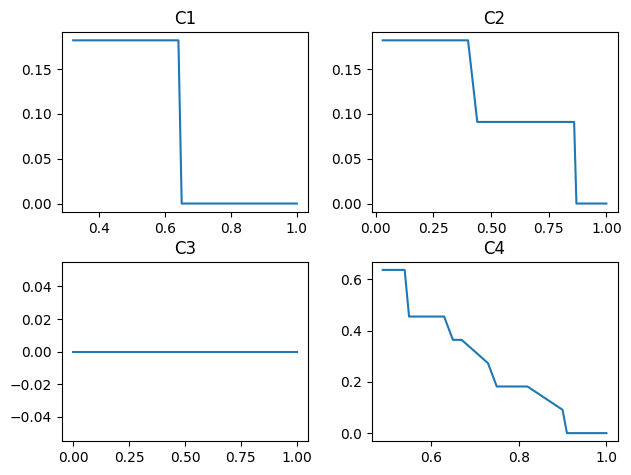

In [56]:
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.5)

make_subplot("C1", axs, 0, 0)
make_subplot("C2", axs, 0, 1)
make_subplot("C3", axs, 1, 0)
make_subplot("C4", axs, 1, 1)

plt.show()

In [57]:
ranking = pd.DataFrame(dataset.copy())

for criterion in dataset.columns:
    ranking[f"U({criterion})"] = [0 for _ in range(27)]
ranking["U"] = [0 for _ in range(27)]

for criterion in dataset.columns:
    for variant in dataset.index:
        u_arg = (dataset[criterion][variant] * 100).astype(np.int8)
        ranking[f"U({criterion})"][variant] += round(u[criterion][u_arg].value(), 10)

for variant in dataset.index:
    ranking["U"][variant] = np.sum(ranking.loc[variant][5:])



ranking.sort_values('U', ascending=False)

C:\Users\HououinKyouma\AppData\Local\Temp\ipykernel_36704\953646167.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ranking[f"U({criterion})"][variant] += round(u[criterion][u_arg].value(), 10)
C:\Users\HououinKyouma\AppData\Local\Temp\ipykernel_36704\953646167.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ranking["U"][variant] = np.sum(ranking.loc[variant][5:])


,C1,C2,C3,C4,U(C1),U(C2),U(C3),U(C4),U
index,,,,,,,,,
5,0.62,0.40,0.56,0.50,0.181818,0.181818,0,0.636364,0.818182
6,0.78,0.27,0.71,0.50,0.000000,0.181818,0,0.636364,0.818182
12,0.74,0.25,0.80,0.49,0.000000,0.181818,0,0.636364,0.818182
11,0.61,0.54,0.38,0.49,0.181818,0.090909,0,0.636364,0.727273
3,1.00,0.45,0.57,0.50,0.000000,0.090909,0,0.636364,0.727273
2,0.66,0.55,0.45,0.49,0.000000,0.090909,0,0.636364,0.727273
8,0.64,0.44,0.54,0.54,0.181818,0.090909,0,0.636364,0.727273
9,0.65,0.30,0.71,0.55,0.000000,0.181818,0,0.454545,0.636364
15,0.87,0.03,1.00,0.61,0.000000,0.181818,0,0.454545,0.636364
